*This is a test. If you can red this it means I successfully work on my branch and pushed the changes

In [18]:
from pathlib import Path
import sys

# Had to add this stuff to get notebook to find files, because it is not
# located in the root folder
ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

from keras import Sequential, Input, layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import regularizers

from bee_tector.config import FULL_DATA_DIR, CURATED_DATA_DIR, MODELS_DIR
from bee_tector.plots import plot_history
from bee_tector.data import (
    load_datasets,
    undersample_dataset,
    load_selected_classes
)

# BeeTector

A deep model for Bombus subspecies prediction

## raw_data

- bombus12_full: full unedited dataset.
- bombus11_curated: edited version where I manually deleted the images where the bees where smaller.

## bombus12_full

- Common Eastern Bumble Bee     944
- Common Carder Bumble Bee      782
- Brown-belted Bumble Bee       698
- Buff-tailed Bumble Bee        553
- Red-tailed Bumble Bee         499
- Two-spotted Bumble Bee        338
- Tricolored Bumble Bee         303
- Yellow-faced Bumble Bee       285
- White-tailed Bumble Bee       243
- American Bumble Bee           218
- Red-belted Bumble Bee         165
- Half-black Bumble Bee         153

## Loading the Data

In [19]:
# ALL

# This loads the full dataset (all classes, as-is)
# _, val_ds, test_ds = load_datasets()   # train_ds will be imbalanced
# rtype -> tf.data.Dataset objects (train, val, test)

# This creates a balanced train dataset by undersampling
# train_ds, id_to_class = undersample_dataset(FULL_DATA_DIR)
# rtype -> (tf.data.Dataset, dict)
# dict maps label_id -> class_name

In [20]:
# SELECTED

# This loads selected classes imbalanced
# wanted = list of wanted classes
# train_ds, val_ds, test_ds = load_selected_classes(wanted_classes=wanted)

# This creates a balanced train dataset by undersampling
# train_ds, id_to_class = undersample_dataset(class_names=wanted)

# This creates a balanced train dataset by undersampling
# train_ds, id_to_class = undersample_dataset(class_names=wanted)

## Baseline Model

In [34]:
def initialize_model(shape=(224, 224, 3)):
    data_augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])

    model = Sequential()

    model.add(Input(shape=shape))
    model.add(data_augmentation)
    model.add(layers.Rescaling(1./255))  # RESCALE!

    model.add(layers.Conv2D(32, (4, 4), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    # I don't really know what this does but you can do this instead of
    # flattening I think
    # model.add(layers.GlobalAveragePooling2D())

    reg = regularizers.l2(1e-5)
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=reg))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=reg))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(12, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

    return model


In [29]:
# Leaving out the most similar-looking classes

wanted = [
    "Common_Carder_Bumble_Bee",
    "Red-tailed_Bumble_Bee",
    "Tricolored_Bumble_Bee",
    "Yellow-faced_Bumble_Bee",
    "American_Bumble_Bee",
    "White-tailed_Bumble_Bee",
    "Buff-tailed_Bumble_Bee",
]

In [30]:
_, val_ds, test_ds = load_selected_classes(wanted_classes=wanted)  # train_ds is imbalanced

Found 2013 files belonging to 7 classes.
Found 435 files belonging to 7 classes.
Found 435 files belonging to 7 classes.


In [31]:
train_ds, id_to_class = undersample_dataset(class_names=wanted)
id_to_class

{0: 'Common_Carder_Bumble_Bee',
 1: 'Red-tailed_Bumble_Bee',
 2: 'Tricolored_Bumble_Bee',
 3: 'Yellow-faced_Bumble_Bee',
 4: 'American_Bumble_Bee',
 5: 'White-tailed_Bumble_Bee',
 6: 'Buff-tailed_Bumble_Bee'}

In [ ]:
baseline_model = initialize_model()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = baseline_model.fit(
    train_ds,
    epochs=1000,
    validation_data=val_ds,
    callbacks=[es],
    verbose=1
)

In [ ]:
val_loss, val_acc = baseline_model.evaluate(val_ds)
print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

test_loss, test_acc = baseline_model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.2391 - loss: 2.0419
Validation loss: 2.0419, Validation accuracy: 0.2391
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.2575 - loss: 1.9883
Test loss: 1.9883, Test accuracy: 0.2575


In [ ]:
# Baseline Model
# Validation loss: 2.0419, Validation accuracy: 0.2391
# Test loss: 1.9883, Test accuracy: 0.2575

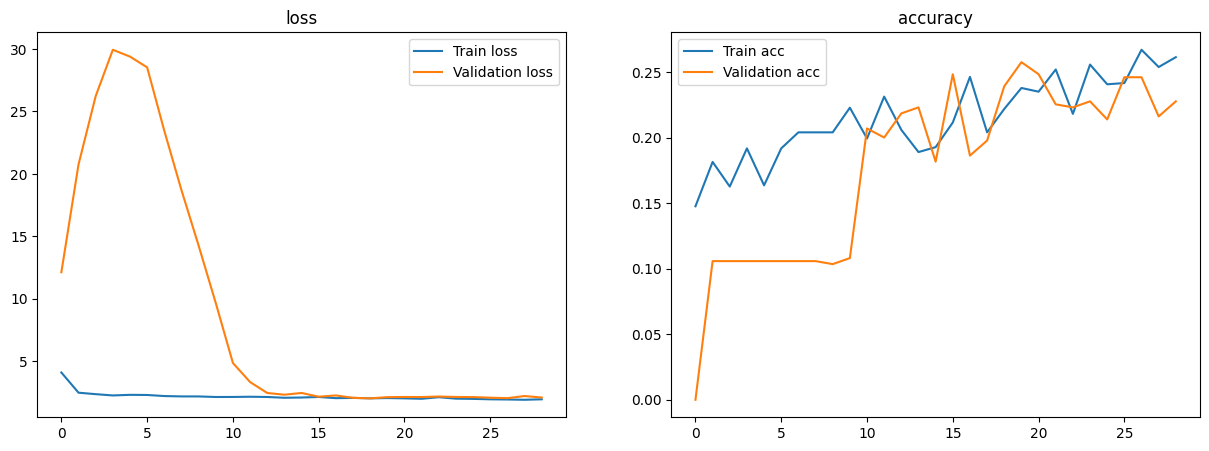

In [15]:
plot_history(history)

In [ ]:
# training loss falls quickly and stabilizes; validation loss was unstable at first but also settled.

# both train and validation accuracy rise and are tracking closely — not extreme overfitting yet...

In [ ]:
# baseline_model.save(MODELS_DIR)

# To load:
# from keras.models import load_model
# baseline_model = load_model(MODELS_DIR / "baseline_model.keras")

## Baseline with curated

In [ ]:
# My highest score of 60% was with 3 unique bees but with curated data. So I wasn't sure if
# editing the dataset had made any difference. From running this, it seems to
# actually have made it worse!

In [35]:
_, val_curated_ds, test_curated_ds = load_selected_classes(data_dir=CURATED_DATA_DIR, wanted_classes=wanted)

Found 1762 files belonging to 7 classes.
Found 381 files belonging to 7 classes.
Found 382 files belonging to 7 classes.


In [36]:
train_curated_ds, id_to_class = undersample_dataset(data_dir=CURATED_DATA_DIR, class_names=wanted)

In [37]:
baseline_curated_model = initialize_model()

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

curated_history = baseline_curated_model.fit(
    train_curated_ds,
    epochs=1000,
    validation_data=val_curated_ds,
    callbacks=[es],
    verbose=1
)

Epoch 1/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 706ms/step - accuracy: 0.1011 - loss: 3.9606 - val_accuracy: 0.1050 - val_loss: 8.8372
Epoch 2/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 733ms/step - accuracy: 0.1137 - loss: 3.0541 - val_accuracy: 0.1050 - val_loss: 16.1890
Epoch 3/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 702ms/step - accuracy: 0.1199 - loss: 2.6419 - val_accuracy: 0.1155 - val_loss: 20.2400
Epoch 4/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.1335 - loss: 2.4755 - val_accuracy: 0.1234 - val_loss: 21.6665
Epoch 5/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.1606 - loss: 2.4439 - val_accuracy: 0.1444 - val_loss: 22.5012
Epoch 6/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 703ms/step - accuracy: 0.1522 - loss: 2.4514 - val_accuracy: 0.1654 - val_loss: 21.0497
Epoch 7/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - accuracy: 0.1658 - loss: 2.4243 - val_accuracy: 0.1339 - val_loss: 19.8045
Epoch 8/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 702ms/step - accuracy: 0.1940 - l

In [38]:
val_curated_loss, val_curated_acc = baseline_curated_model.evaluate(val_curated_ds)
print(f"Validation loss: {val_curated_loss:.4f}, Validation accuracy: {val_curated_acc:.4f}")

test_curated_loss, test_curated_acc = baseline_curated_model.evaluate(test_curated_ds)
print(f"Test loss: {test_curated_loss:.4f}, Test accuracy: {test_curated_acc:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.1050 - loss: 8.8372
Validation loss: 8.8372, Validation accuracy: 0.1050
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.1073 - loss: 8.7820 
Test loss: 8.7820, Test accuracy: 0.1073


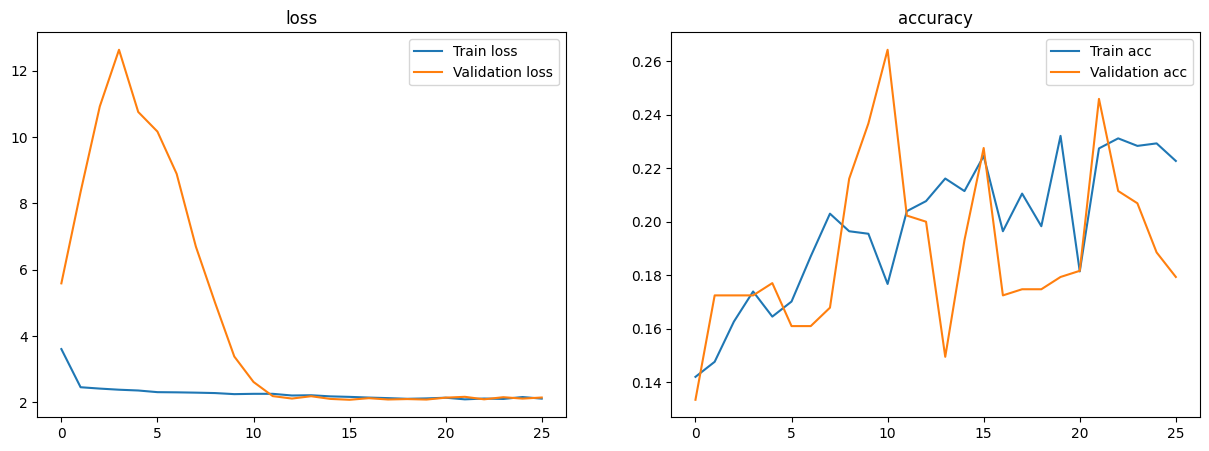

In [39]:
plot_history(history)